<div style = "height: 50px;"></div>

# 필요한 모듈 불러오기

In [1]:
# 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import re
import numpy               as np
import matplotlib.pyplot   as plt
import pandas              as pd
import tensorflow_datasets as tfds
import tensorflow          as tf
import tensorflow_datasets as tfds

<div style = "height: 50px;"></div>

# 함수 정의하기

In [4]:
# 문장 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    
    # "I am a student." => "I am a student ."와 같이
    # 단어 와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    return sentence

In [37]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
          
      # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [33]:
# 문장의 길이 구하는 함수 
def x_len(x):
    len_list = []
    for i in x[:]:
        len_list.append(len(i))
    return len_list

In [6]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [7]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [8]:
# 멀티 헤드 어텐션 클래스
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [9]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [10]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [11]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
  
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
  
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)
  
    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)
  
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name
    )
  

In [12]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
  
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
  
    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
  
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)  

In [13]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [14]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
  
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
  
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [15]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
  
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
  
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
  
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
  
    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])
  
    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
  
    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
  
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [16]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
  
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
  
    return tf.reduce_mean(loss)  

In [17]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [18]:
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


In [19]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
      # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
  
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
  
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
  
        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [20]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)
  
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
  
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
  
    return predicted_sentence

<div style = "height: 50px;"></div>

# <span style = "font-weight:bold;color:#0172d4;">STEP 1</span> : 데이터 불러오기 및 데이터 병렬화하기

## 1. 데이터 불러오기
<hr/>

In [3]:
chatbot_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ex11/data/ChatbotData.csv')

In [21]:
chatbot_data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


<div style = "height: 50px;"></div>

## 2. 데이터 questions와 answers로 분리하기
<hr/>

In [22]:
questions = chatbot_data['Q'].to_list()
answers = chatbot_data['A'].to_list()
target = chatbot_data['label'].to_list()

In [23]:
questions = []

for i in chatbot_data['Q'].to_list():
    questions.append(preprocess_sentence(i))

In [24]:
answers = []

for i in chatbot_data['A'].to_list():
    answers.append(preprocess_sentence(i))

In [25]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 . 


<div style = "height: 50px;"></div>

# <span style = "font-weight:bold;color:#0172d4;">STEP 2</span> : Tokenizing 및 병렬 데이터 전처리하기

## 1. 단어장(Vocabulary) 만들기
<hr/>

In [26]:
# 질문과 답변 데이터셋에 대해서 Vocabulary(단어장) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size = 2**13)

In [27]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [28]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [29]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


<div style = "height: 50px;"></div>

## 2. 각 단어를 고유한 정수로 인코딩(Integer encoding)하기
<hr/>

In [30]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5760, 609, 2489, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7510, 7, 6273, 96, 1]


In [32]:
# for문으로 모든 문장을 정수 인코딩 하기
inputs, outputs = [], []

for (sentence1, sentence2) in zip(questions, answers):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    
    inputs.append(sentence1)
    outputs.append(sentence2)

print(inputs)
print(outputs)

[[8170, 7909, 4200, 3054, 38, 8171], [8170, 7963, 46, 916, 7946, 996, 1712, 8171], [8170, 7965, 1432, 4646, 7946, 3645, 66, 8171], [8170, 7965, 1432, 4646, 7946, 1292, 3645, 66, 8171], [8170, 8026, 8026, 8022, 7946, 4183, 8171], [8170, 8029, 8014, 2186, 916, 77, 819, 8171], [8170, 8029, 8014, 2186, 199, 8171], [8170, 1944, 643, 1127, 7946, 65, 5110, 850, 8171], [8170, 1944, 780, 7606, 172, 8, 2564, 433, 47, 202, 8171], [8170, 1944, 780, 7606, 203, 83, 183, 350, 1256, 8171], [8170, 5774, 481, 194, 2978, 44, 3811, 8171], [8170, 684, 745, 8171], [8170, 684, 7197, 30, 745, 8171], [8170, 2734, 3799, 5, 765, 8171], [8170, 77, 741, 22, 147, 53, 958, 948, 8171], [8170, 77, 61, 1144, 5481, 1571, 8171], [8170, 77, 452, 487, 8151, 8057, 8058, 7946, 4828, 456, 7277, 8171], [8170, 5760, 7054, 3878, 15, 5619, 8171], [8170, 5760, 7054, 3878, 1112, 3666, 8, 36, 8171], [8170, 5760, 609, 6, 18, 3110, 54, 1, 8171], [8170, 5760, 609, 3502, 140, 683, 3740, 847, 8171], [8170, 5760, 609, 2489, 4160, 8171], [

<div style = "height: 50px;"></div>

## 3. 패딩(Padding)하기
<hr/>

### 문장의 길이 시각화하기

In [34]:
# 문장의 길이 함수로 구하기
inputs_len = x_len(inputs)
outputs_len = x_len(outputs)

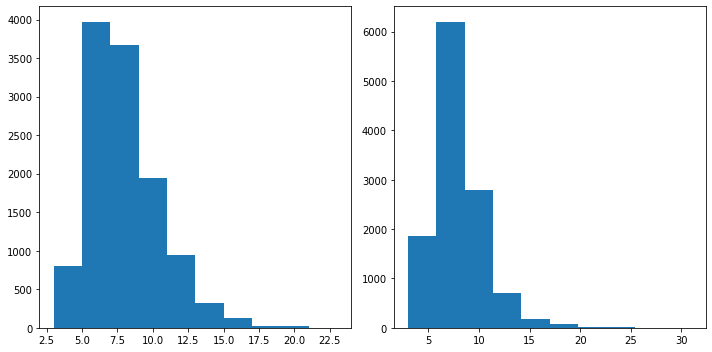

In [35]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.hist(inputs_len)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.hist(outputs_len)
plt.tight_layout()
plt.show()

### 문장 샘플의 최대 길이 지정하기

In [36]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 15
print(MAX_LENGTH)

15


<div style = "height: 25px;"></div>

### 최대 길이를 초과하는 샘플 제거, 시작 토큰과 종료 토큰 추가, 패딩하기

In [38]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11568
필터링 후의 답변 샘플 개수: 11568


<div style = "height: 50px;"></div>

## 4. 교사 강요(Teacher Forcing) 사용하기
<hr/>

In [42]:
BATCH_SIZE = 130
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

<p style= "font-size:15px; line-height:24px;">질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성함.<br/>
이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용한다.</p>

<div style = "height: 50px;"></div>

# <span style = "font-weight:bold;color:#0172d4;">STEP 3</span> : 모델 구성하기

## 1. 모델 생성하기
<hr/>

In [39]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3146240     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

<div style = "height: 50px;"></div>

## 2. 학습률(Learning rate) 커스텀하기
<hr/>

Text(0.5, 0, 'Train Step')

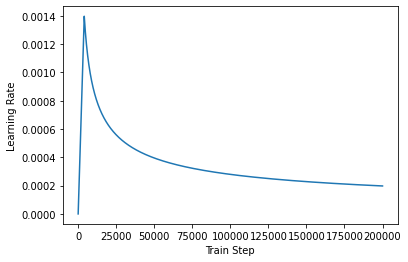

In [40]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

<div style = "height: 50px;"></div>

## 3. 모델 컴파일
<hr/>

In [41]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

<div style = "height: 50px;"></div>

## 4. 모델 훈련하기
<hr/>

In [43]:
EPOCHS = 100
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
89/89 [==============================] - 11s 48ms/step - loss: 4.1601 - accuracy: 0.0363
Epoch 2/100
89/89 [==============================] - 4s 48ms/step - loss: 3.7649 - accuracy: 0.0829
Epoch 3/100
89/89 [==============================] - 4s 48ms/step - loss: 3.3723 - accuracy: 0.1381
Epoch 4/100
89/89 [==============================] - 4s 49ms/step - loss: 3.0087 - accuracy: 0.1400
Epoch 5/100
89/89 [==============================] - 4s 50ms/step - loss: 2.7524 - accuracy: 0.1415
Epoch 6/100
89/89 [==============================] - 4s 48ms/step - loss: 2.5821 - accuracy: 0.1479
Epoch 7/100
89/89 [==============================] - 4s 47ms/step - loss: 2.4617 - accuracy: 0.1546
Epoch 8/100
89/89 [==============================] - 4s 47ms/step - loss: 2.3568 - accuracy: 0.1602
Epoch 9/100
89/89 [==============================] - 4s 48ms/step - loss: 2.2538 - accuracy: 0.1667
Epoch 10/100
89/89 [==============================] - 4s 48ms/step - loss: 2.1492 - accuracy: 0.175

<p style= "font-size:15px; line-height:24px;"><span style = 'background-color:#fff5b1; padding:0.2px;'>최종 loss값이 0.0058</span>, <span style = 'background-color:#fff5b1; padding:0.2px;'>accuracy값은 0.4</span>로 loss값에 비해 정확도가 높지 않은 것을 확인하였다.<br/>
loss값이 0에 가까우나 이 값이 모델에 있어 작지 않음을 의미하는 것으로 판단된다.</p>

<div style = "height: 50px;"></div>

## 5. 모델 loss값 시각화하기
<hr/>

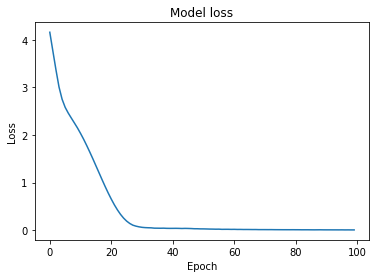

In [55]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

<div style = "height: 50px;"></div>

# <span style = "font-weight:bold;color:#0172d4;">STEP 4</span> : 모델 평가하기

In [44]:
sentence_generation('자니?')

입력 : 자니?
출력 : 기다리고 있었어요 . 


'기다리고 있었어요 . '

In [45]:
sentence_generation('안녕?')

입력 : 안녕?
출력 : 안녕하세요 . 


'안녕하세요 . '

In [46]:
sentence_generation("바보")

입력 : 바보
출력 : 실수했나요 . 


'실수했나요 . '

In [47]:
sentence_generation('밥먹었어?')

입력 : 밥먹었어?
출력 : 저는 배터리가 밥이예요 . 


'저는 배터리가 밥이예요 . '

In [48]:
sentence_generation('오늘 날씨가 좋아')

입력 : 오늘 날씨가 좋아
출력 : 집밖에 나가기가 힘들것 같아요 . 


'집밖에 나가기가 힘들것 같아요 . '

In [49]:
sentence_generation('오늘 비오네')

입력 : 오늘 비오네
출력 : 주룩주룩 . 


'주룩주룩 . '

In [51]:
sentence_generation('대단하네')

입력 : 대단하네
출력 : 사랑의 예의가 없네요 . 


'사랑의 예의가 없네요 . '

In [52]:
sentence_generation('내가 미안해')

입력 : 내가 미안해
출력 : 괜찮아요 . 


'괜찮아요 . '

In [53]:
sentence_generation('응 그래')

입력 : 응 그래
출력 : 네


'네'

In [54]:
sentence_generation('잘자')

입력 : 잘자
출력 : 내 꿈 꿔 ! 


'내 꿈 꿔 ! '

<p style= "font-size:15px; line-height:24px;">accuracy값은 0.4로, 높지 않음에도 불구하고 가끔 출력이 이상하게 나오지만, 꽤 그럴듯한 문장을 출력한다.<br/></p>

<div style = "height: 50px;"></div>

# <span style = "font-weight:bold;color:#0172d4;">STEP 4</span> : 회고

## 트랜스포머 이해에 도움이 될 자료들
<hr/>

<ul style = "margin-bottom:30px;">
	<li style = "margin-bottom:14px;"><a href = "https://aistudy9314.tistory.com/63" style = "font-size:16px;">Attention is all you need 리뷰 블로그</a></li>
	<li style = "margin-bottom:14px;"><a href = "https://www.youtube.com/watch?v=mxGCEWOxfe8" style = "font-size:16px;">트랜스포머(Attention is all you need): 유튜브 영상</a></li>
	<li style = "margin-bottom:14px;"><a href = "https://arxiv.org/pdf/1706.03762.pdf" style = "font-size:16px;">Attention is all you need 논문</a></li>
	<li style = "margin-bottom:14px;"><a href = "https://ratsgo.github.io/" style = "font-size:16px;">[do it bert와 gpt로 배우는 자연어 처리]저자의 github</a></li>
</ul>

<p style= "font-size:16px; line-height:30px;">이 중 1번째와 4번째 링크가 가장 도움이 되었으며, 후에 트랜스포머를 다시 사용할 경우, 위의 4가지 링크를 확인하면 좋을 것 같다.</p>

<div style = "height: 50px;"></div>

## 느낀점
<hr/>

<p style= "font-size:16px; line-height:30px;">옛날에 유명했던 '심심이'같은 챗봇을 만든다는 것이 신기했습니다. 또한 과정을 모두 진행했음에도 불구하고 트랜스포머를 잘 이해하지 못한 것이 아쉽습니다.<br/>모두 다 이해는 하지 못했고, 대신 미래에 다시 찾아보게 될 수도 있으므로, 그나마 도움이 되었던 링크를 첨부하였습니다.<br/><br/>
전체적으로 모든 진행을 함수로 처리하여 과정을 진행하는데에 편했으나, 이를 이해하고자 한줄씩 실행시켰었는데, 이 과정을 끝까지 진행하기에는 어려움이 있어 완료하지 못한 것이 아쉽습니다. (내용이 너무 길어져 가독성을 위해 익스 제출에는 삭제되었습니다.)<br/><br/>아쉬움이 많이 남은 프로젝트이기 때문에 후에 시간이 난다면 다시 한번 더 스스로 진행하여 트랜스포머를 이해하고자 합니다.
</p>

<div style = "height: 50px;"></div>